In [1]:
import numpy as np
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import glob
import os
import h5py
import librosa
import umap
import soundfile as sf

from tqdm import tqdm
from pathlib import Path
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

sample_rate = 8000 #minimum 8000 for sf.write 

5 second clip splitter

In [2]:
def split(loaded_audio, file_name, clip_length = 5):
    chunk_samples = int(clip_length * sample_rate)
    chunks = [loaded_audio[i:i + chunk_samples] for i in range(0, len(loaded_audio), chunk_samples)]
    for i, chunk in enumerate(chunks): #thank u stack for this cool iterative
        output_file = f"fma_generated/{file_name}{i}.mp3"
        sf.write(output_file, chunk, sample_rate)
    
temp, _ = librosa.load('./fma_small/000/000002.mp3', sr=sample_rate)
temp = librosa.util.normalize(temp)
split(temp, '000002')

In [3]:
#total 8000 tracks
def load_batches(root_path, sample_rate, batch_size, clip_length = 5, output_dir='./fma_generated'):
    os.makedirs(output_dir, exist_ok=True)
    file_paths=[]
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))
                #print(file)
                
    np.random.seed(88)
    np.random.shuffle(file_paths)
    
    
    chunk_samples = int(clip_length * sample_rate) #actual number of samples per chunkclip
    
    
    file_index = 0
    batch_index = 0
    while file_index < len(file_paths):
        batch_clips=[]
        bathchs=[]
        while len(batch_clips)<batch_size and file_index < len(file_paths):
            file_path = file_paths[file_index]
            try:
                #print(f"processing {os.path.basename(file_path)}")
                
                audio, _ = librosa.load(file_path, sr=sample_rate)
                filename = os.path.splitext(os.path.basename(file_path))[0]
                
                clip_index = 0
                for i in range(0,len(audio), chunk_samples):
                    chunk = audio[i:i+chunk_samples]
                    
                    if len(chunk) == chunk_samples: #exactly 5 seconds
                        clip_filename = f"{filename}{clip_index:01d}.mp3" #single digit index :o
                        clip_path = os.path.join(output_dir, clip_filename)
                        
                        sf.write(clip_path, chunk, sample_rate)
                        batch_clips.append(chunk.copy()) #avoid ref issues
                        bathchs.append(clip_path)
                        clip_index += 1
                        
                        if len(batch_clips) >= batch_size:
                            break
            except Exception as e:
                #print(f"error loading {file_path}: {str(e)}")
                continue
            file_index+=1
        if len(batch_clips) > 0:
            print(f"batch {batch_index+1} with {len(batch_clips)} clips")
            
            yield batch_clips.copy(), bathchs.copy()
            del batch_clips, bathchs
            batch_index += 1
            
        else: break

In [4]:
def clear_generated(generated_dir='./fma_generated'):
    if os.path.exists(generated_dir):
        for file in tqdm(os.listdir(generated_dir)):
            if file.endswith('.mp3'):
                os.remove(os.path.join(generated_dir, file))
        os.rmdir(generated_dir)
        print(f"deleted absolutely everything within the following. directory. {generated_dir}")

In [5]:
clear_generated('./fma_generated')
batch_size = 5000 #how many clips, not how many files r processed. btw
big_data = load_batches('./fma_small', sample_rate, batch_size) #generator function
batches=[]
pathches=[]


small_data, file_paths = next(big_data)
batches.append(small_data)
pathches.append(file_paths)

100%|██████████| 5006/5006 [00:00<00:00, 14488.52it/s]


deleted absolutely everything within the following. directory. ./fma_generated


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


batch 1 with 5000 clips


investigation.
https://stackoverflow.com/questions/65160046/librosa-does-not-normalize-wave-file-between-1-1

In [6]:
print(len(batches[0])) #first batch is 100 clips
print(len(batches[0][0])) #each clip is 30sec*5512 samples
print(batches[0][0]) #each sample 
print(np.mean(batches[0][0]))
print(np.std(batches[0][0]))

5000
40000
[ 1.9267792e-09  3.9689185e-09 -5.0188205e-09 ...  2.4918647e-01
  2.5008139e-01  1.9099995e-01]
-1.6623706e-06
0.124991134


choose either standardization or normalization. normalize for models
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [7]:
import scipy
def into_melspecs(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    #mel_db=librosa.power_to_db(mel_spec, ref=np.max) #scale to 1.0? perhaps??
    #librosa.display.specshow(mel_db, fmax=None, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    
    if mel_spec.max() == mel_spec.min():
        #i'm getting nans???
        return False
    
    #mel_normalized=2 * (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()) - 1
    flattened = mel_spec.flatten()
    #mel_standardized = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    #flattened = mel_standardized.flatten()
    return flattened

def into_textures(mel_spec, power = 2.0): #mel-frequency cepstrum. timbre
    if mel_spec is False or mel_spec is None:
        return False
    try: 
        logged = np.log(mel_spec + np.full_like(mel_spec, 1e-5))
        dct_powered = scipy.fft.dct(np.power(logged, power))
        normalized_textures = (dct_powered - np.mean(dct_powered)) / (np.std(dct_powered))
        return normalized_textures
    except Exception as e:
        print(f"{e}")
        return False

def into_freqs(audio, sample_rate):
    output, _, probabilities = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sample_rate, pad_mode='constant', n_thresholds = 10)
    output = np.nan_to_num(output, -1)
    #512 step
    return output, probabilities

test, testprob = into_freqs(batches[0][3], sample_rate)
test2 = into_textures(into_melspecs(batches[0][0], sample_rate))
print(f"{test.shape}\n{test}\n{test2.shape}")
#x128

(79,)
[ 83.84733628  83.84733628 146.83238396 146.83238396 145.98669166
  88.321517    88.83315835   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          67.32294488  67.32294488  67.32294488
  66.93519325  66.54967491  66.54967491  66.93519325   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          74.69948441  73.84148765  74.26924704
  81.93226047  82.40688923  81.93226047  81.93226047  81.93226047
   0.           0.           0.           0.        ]
(10112,)



Analyzing Clip 1...
Frequencies shape: (79,)
Number of NaN values: 0
Number of valid values: 79
Frequency range: 0.0 - 111.3 Hz
Plotted 79 valid pitch points


/var/folders/v7/96pnb7v52cn4swxgq3j09dbm0000gq/T/ipykernel_91270/146543406.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


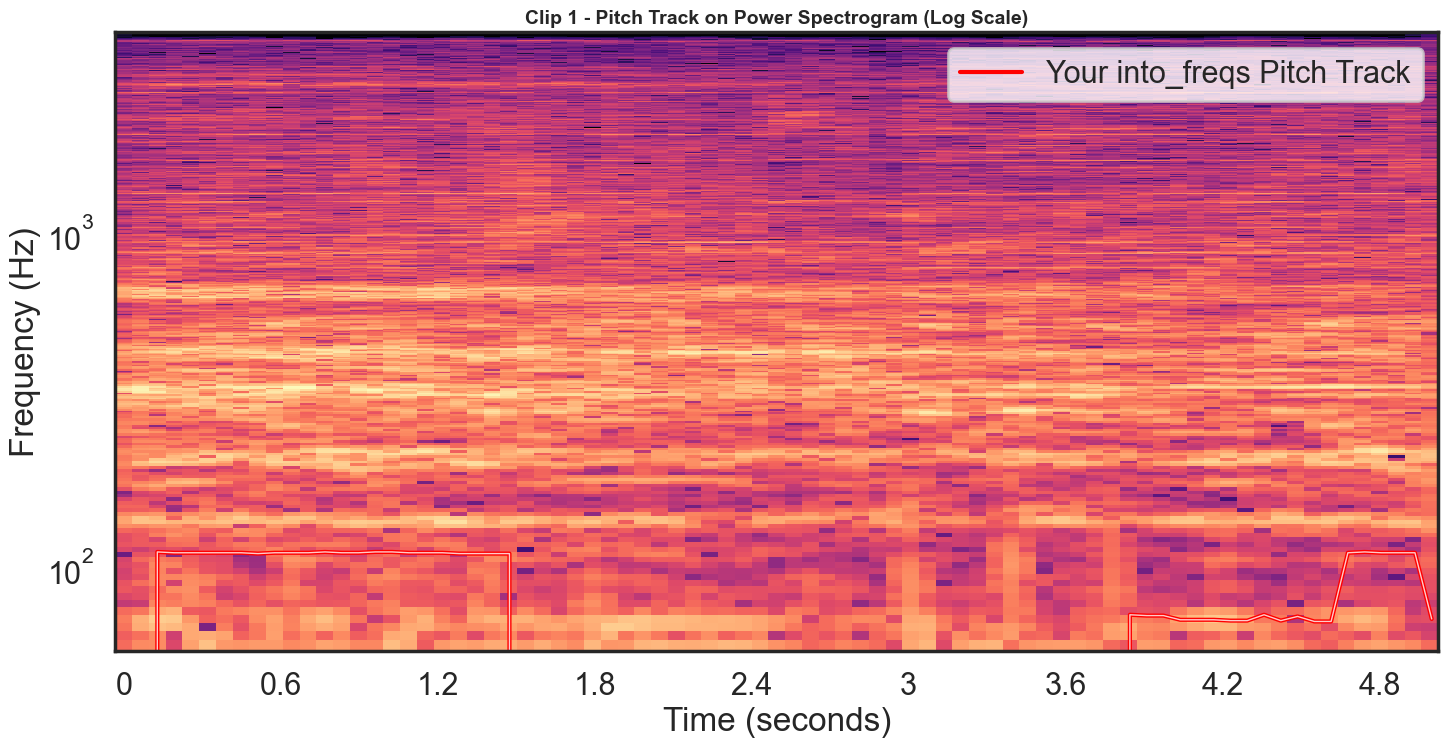

  Valid frames: 79/79 (100.0%)

Analyzing Clip 2...
Frequencies shape: (79,)
Number of NaN values: 0
Number of valid values: 79
Frequency range: 70.5 - 78.7 Hz
Plotted 79 valid pitch points


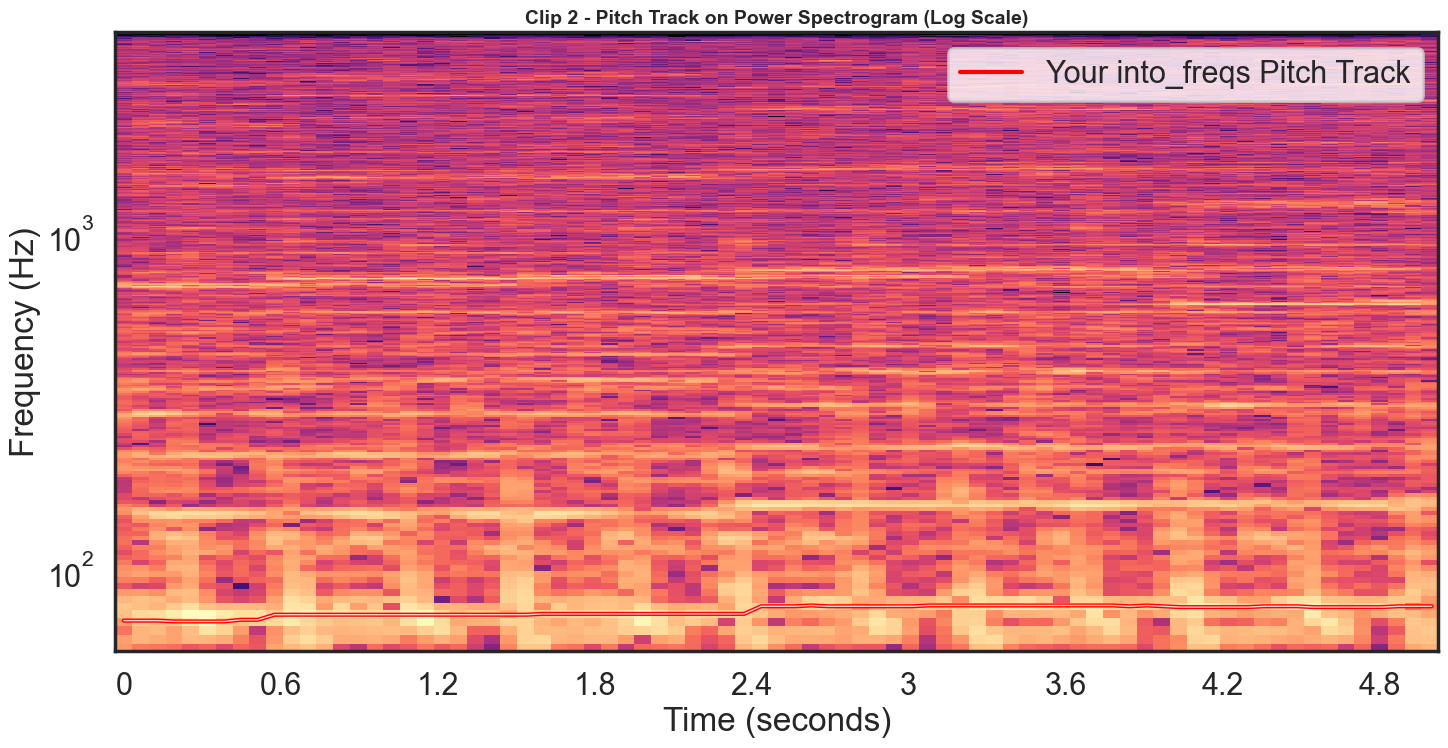

  Valid frames: 79/79 (100.0%)

Analyzing Clip 3...
Frequencies shape: (79,)
Number of NaN values: 0
Number of valid values: 79
Frequency range: 122.8 - 309.3 Hz
Plotted 79 valid pitch points


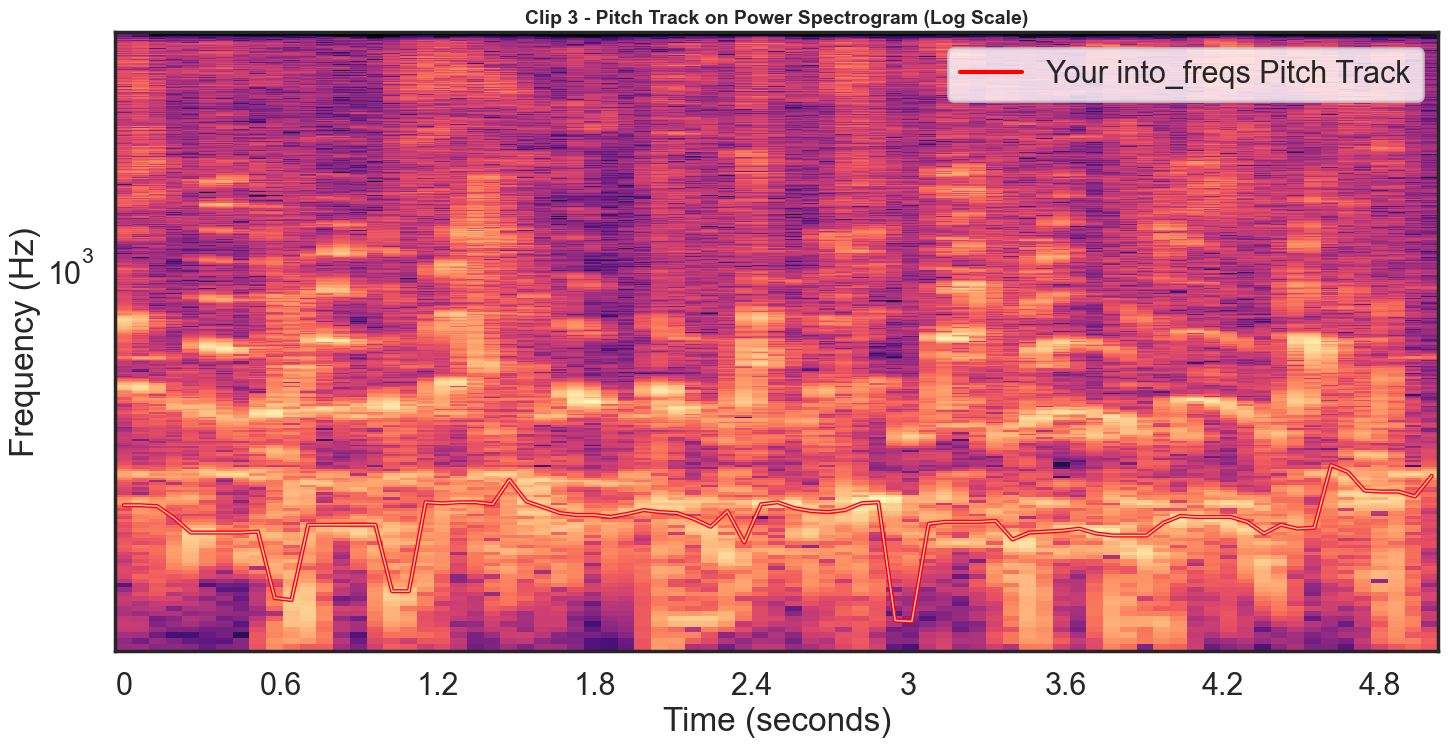

  Valid frames: 79/79 (100.0%)
./fma_generated/1459185.mp3, ./fma_generated/1335634.mp3, ./fma_generated/1345093.mp3


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

def visualize_into_freqs_on_spectrogram(audio, sample_rate, title="Pitch Track on Spectrogram"):
    """
    Plot your into_freqs pitch track overlaid on the power spectrogram with log y-axis
    
    Parameters:
    audio: numpy array of audio samples
    sample_rate: sample rate of the audio
    title: title for the plot
    """
    
    # Use YOUR into_freqs function - it returns a tuple (frequencies, probabilities)
    frequencies, probabilities = into_freqs(audio, sample_rate)
    
    # Debug info
    print(f"Frequencies shape: {frequencies.shape}")
    print(f"Number of NaN values: {np.sum(np.isnan(frequencies))}")
    print(f"Number of valid values: {np.sum(~np.isnan(frequencies))}")
    if np.any(~np.isnan(frequencies)):
        print(f"Frequency range: {np.nanmin(frequencies):.1f} - {np.nanmax(frequencies):.1f} Hz")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create POWER spectrogram (squared magnitude)
    D = librosa.power_to_db(np.abs(librosa.stft(audio))**2, ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz', ax=ax)
    
    # Set y-axis to logarithmic scale
    ax.set_yscale('log')
    
    # Overlay pitch track from your into_freqs
    time_pitch = np.linspace(0, len(audio) / sample_rate, len(frequencies))
    valid_mask = ~np.isnan(frequencies)
    
    if np.any(valid_mask):
        # Get valid indices
        valid_indices = np.where(valid_mask)[0]
        valid_times = time_pitch[valid_indices]
        valid_freqs = frequencies[valid_indices]
        
        # Plot the pitch track
        ax.plot(valid_times, valid_freqs, 
                color='red', linewidth=3, label='Your into_freqs Pitch Track')
        ax.plot(valid_times, valid_freqs, 
                color='white', linewidth=1, alpha=0.8)  # White outline for visibility
        
        print(f"Plotted {len(valid_times)} valid pitch points")
    else:
        print("No valid frequencies found to plot")
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (seconds)')
    ax.legend()
    
    plt.tight_layout()
    return fig, frequencies

def visualize_multiple_clips_spectrograms(clips, sample_rate, clip_names=None, max_clips=4):
    """
    Visualize multiple clips with power spectrograms and pitch tracks (log y-axis)
    """
    n_clips = min(len(clips), max_clips)
    
    if clip_names is None:
        clip_names = [f'Clip {i+1}' for i in range(n_clips)]
    
    fig, axes = plt.subplots(n_clips, 1, figsize=(15, 4*n_clips))
    if n_clips == 1:
        axes = [axes]
    
    for i in range(n_clips):
        # Use YOUR into_freqs function - it returns a tuple
        frequencies, probabilities = into_freqs(clips[i], sample_rate)
        
        # Create POWER spectrogram
        D = librosa.power_to_db(np.abs(librosa.stft(clips[i]))**2, ref=np.max)
        librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz', ax=axes[i])
        
        # Set y-axis to logarithmic scale
        axes[i].set_yscale('log')
        
        # Overlay pitch track
        time_pitch = np.linspace(0, len(clips[i]) / sample_rate, len(frequencies))
        valid_mask = ~np.isnan(frequencies)
        
        if np.any(valid_mask):
            valid_indices = np.where(valid_mask)[0]
            valid_times = time_pitch[valid_indices]
            valid_freqs = frequencies[valid_indices]
            
            axes[i].plot(valid_times, valid_freqs, 
                        color='red', linewidth=3, label='Pitch Track')
            axes[i].plot(valid_times, valid_freqs, 
                        color='white', linewidth=1, alpha=0.8)
        
        axes[i].set_title(f'{clip_names[i]} - Power Spectrogram with Pitch Track (Log Scale)')
        axes[i].legend()
        
        if i == n_clips - 1:  # Add x-label to bottom plot
            axes[i].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    return fig

# Example usage with your existing data
def demo_spectrogram_only():
    """Demo with just power spectrogram and pitch track (log y-axis)"""
    
    # Test with specific clips from your data
    test_clips = [batches[0][i] for i in [10, 20, 30]]  # Clips at indices 10, 20, 30
    
    for i, clip in enumerate(test_clips):
        print(f"\nAnalyzing Clip {i+1}...")
        
        # Create visualization
        fig, freqs = visualize_into_freqs_on_spectrogram(
            clip, sample_rate, f"Clip {i+1} - Pitch Track on Power Spectrogram (Log Scale)"
         )
        plt.show()
        
        # Print some quick stats
        valid_freqs = ~np.isnan(freqs)
        if np.any(valid_freqs):
            print(f"  Valid frames: {np.sum(valid_freqs)}/{len(freqs)} ({np.mean(valid_freqs):.1%})")

# Run the demo
demo_spectrogram_only()

print(f"{pathches[0][10]}, {pathches[0][20]}, {pathches[0][30]}")

filtering out that one clip that's not the right length

In [9]:
%%time
batches_mels=[]
pathches_mels=[]
freqs=[]
probs=[]

temp=[]
tempfreqs=[]
tempprobs=[]

print(f'initial lengths:\n batches[0]: {len(batches[0])} \n pathches[0]: {len(pathches[0])}')
for i, clip in enumerate(tqdm(batches[0], desc='into freqs processing')):
   mel_specs = into_melspecs(clip, sample_rate)
   mel_harmonics, probabilities = into_freqs(clip, sample_rate)
   if mel_specs is False:
      print(f'failure at {i} spectrogram')
      temp.append(False)
      tempfreqs.append(False)
      tempprobs.append(False)
      continue
   mel_texture = into_textures(mel_specs)
   if mel_texture is False:
      print(f'failure at {i} texture')
      temp.append(False)
      tempfreqs.append(False)
      tempprobs.append(False)
      continue
   temp.append(mel_texture) 
   tempfreqs.append(mel_harmonics)
   tempprobs.append(probabilities)
   
   
   
batches_mels.append(temp)
freqs.append(tempfreqs)
probs.append(tempprobs)
pathches_mels.append(pathches[0])

lengths = [len(i) for i in batches_mels[0] if i is not False]
most_common_length = max(set(lengths), key=lengths.count)
filtered_paths = [path for mel, path in zip(batches_mels[0], pathches[0]) if mel is not False and len(mel) == most_common_length]
filtered_freqs = [freq for mel, freq in zip(batches_mels[0], freqs[0]) if mel is not False and len(mel) == most_common_length]
filtered_probs = [prob for mel, prob in zip(batches_mels[0], probs[0]) if mel is not False and len(mel) == most_common_length]
filtered_mels = [mel for mel in batches_mels[0] if mel is not False and len(mel) == most_common_length]

print(f"\nsummary!")
print(f"initial total: {len(batches[0])}")
print(f"filtered mels count: {len(filtered_mels)}")
print(f"filtered paths count: {len(filtered_paths)}")

batches_mels[0] = np.array(filtered_mels, dtype=np.float32)
freqs[0] = filtered_freqs
probs[0] = filtered_probs
pathches_mels[0] = filtered_paths
freq_count = len(freqs[0][0])

initial lengths:
 batches[0]: 5000 
 pathches[0]: 5000


into freqs processing:  27%|██▋       | 1335/5000 [09:16<20:50,  2.93it/s]

failure at 1334 spectrogram


into freqs processing:  27%|██▋       | 1336/5000 [09:17<20:44,  2.95it/s]

failure at 1335 spectrogram


into freqs processing: 100%|██████████| 5000/5000 [32:31<00:00,  2.56it/s]



summary!
initial total: 5000
filtered mels count: 4998
filtered paths count: 4998
CPU times: user 26min 25s, sys: 4min 43s, total: 31min 9s
Wall time: 32min 33s


In [10]:
import numba
import numpy as np
def create_euclidean_both(most_common_length, freq_count):
    most_common_length = int(most_common_length)
    freq_count = int(freq_count)
    @numba.njit()
    def euclidean_timbre(a, b):
        return np.linalg.norm(a[:most_common_length]-b[:most_common_length])
        

    @numba.njit()
    def euclidean_freq(a, b):
        
        freq_dists = np.nan_to_num(np.log(a[most_common_length:most_common_length+freq_count]/b[most_common_length:most_common_length+freq_count]), nan=-1.0)
        timbretemp = 0.0
        freqtemp = 0.0
        for i in range(len(freq_dists)):
            if freq_dists[i]<0.0: #either clip was just unsure? then timbre dominates
                timbretemp += (a[i*128]-b[i*128])**2
                continue
            note_dist=min(abs(freq_dists[i]%0.69315), abs(freq_dists[i]%-0.69315)) #~log 2
            freqtemp+=(note_dist**2)*(a[most_common_length+freq_count+i])*(b[most_common_length+freq_count+i])
            
            #more confident pitches have more distance. but this does push noisy stuff together
        return ((np.sqrt(freqtemp))*128+np.sqrt(timbretemp))*5
    @numba.njit()
    def euclidean_both(a, b):
        return euclidean_freq(a, b)#+euclidean_timbre(a, b)
    
    return euclidean_both
# combined = np.concatenate([batches_mels[0], freqs[0], probs[0]], axis=1)
# euclidean_both = create_euclidean_both(most_common_length, freq_count)
# timbresum=0
# freqsum=0
# for i in range(150):
#     for j in range(i+1, 150):
#         addtimbre, addfreq = euclidean_both(combined[i], combined[j])
#         timbresum+=addtimbre
#         freqsum+=addfreq
# print(f"freq: {freqsum}, timbre: {timbresum}")


In [11]:
%%time
#freq_count = len(freqs[0][0])
combined = np.concatenate([batches_mels[0], freqs[0], probs[0]], axis=1)
euclidean_both = create_euclidean_both(most_common_length, freq_count)
unsup_embedding = umap.UMAP(n_neighbors=30, metric = euclidean_both).fit_transform(combined)

/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPU times: user 2min 10s, sys: 3.34 s, total: 2min 13s
Wall time: 39.5 s


In [12]:
print(len(batches_mels[0]))
print(len(filtered_mels))
print(len(pathches_mels[0]))

4998
4998
4998


thank you gpt. i would never read all this documentation

In [13]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os
import flask
import librosa
import numpy as np

# After your UMAP processing and filtering...
# Create DataFrame from your clip data
def create_clip_dataframe(umap_embedding, pathches_mels):
    """
    Create DataFrame for clips instead of full audio files
    """
    df = pd.DataFrame({
        'UMAP1': umap_embedding[:, 0],
        'UMAP2': umap_embedding[:, 1], 
        'Clip_Path': pathches_mels,
        'Original_File': [extract_original_filename(path) for path in pathches_mels],
        'Clip_Index': [extract_clip_index(path) for path in pathches_mels]
    })
    
    # Create audio URLs for serving
    df['audio_url'] = df['Clip_Path'].apply(get_clip_audio_url)
    
    return df

def extract_original_filename(clip_path):
    """Extract original filename from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 000002
    basename = os.path.basename(clip_path)
    # Remove extension and clip suffix
    name_without_ext = os.path.splitext(basename)[0]
    # Split on '_clip_' and take first part
    if '_clip_' in name_without_ext:
        return name_without_ext.split('_clip_')[0]
    return name_without_ext

def extract_clip_index(clip_path):
    """Extract clip index from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 0
    basename = os.path.basename(clip_path)
    name_without_ext = os.path.splitext(basename)[0]
    if '_clip_' in name_without_ext:
        try:
            return int(name_without_ext.split('_clip_')[1])
        except (ValueError, IndexError):
            return 0
    return 0

def get_clip_audio_url(clip_path):
    """Convert clip path to URL for serving"""
    # ./fma_generated/000002_clip_000.mp3 -> /audio/000002_clip_000.mp3
    filename = os.path.basename(clip_path)
    return f'/audio/{filename}'

# Create your DataFrame
df = create_clip_dataframe(unsup_embedding, pathches_mels[0])

# Initialize Dash app
app = dash.Dash(__name__)

# Set up audio serving directory (your generated clips)
AUDIO_DIR = os.path.abspath('fma_generated')  # Changed from 'fma_small' to 'fma_generated'

@app.server.route('/audio/<path:filename>')
def serve_audio(filename):
    """Serve audio clips from fma_generated directory"""
    if '..' in filename or filename.startswith('/'):
        flask.abort(404)
    return flask.send_from_directory(AUDIO_DIR, filename)

# Create the scatter plot
fig = px.scatter(
    df, 
    x="UMAP1", 
    y="UMAP2", 
    hover_data=["Original_File", "Clip_Index"], 
    custom_data=['audio_url'],
    title="UMAP",
    labels={'UMAP1': 'Arbitrary Dimension 1', 'UMAP2': 'Arbitrary Dimension 2'}
)

fig.update_layout(
    autosize=True,
    height=600  # Set minimum height
)

# Update hover template to show clip info
fig.update_traces(
    hovertemplate="<b>Original File:</b> %{customdata[1]}<br>" +
                  "<b>Clip Index:</b> %{customdata[2]}<br>" +
                  "<b>UMAP1:</b> %{x}<br>" +
                  "<b>UMAP2:</b> %{y}<extra></extra>"
)

app.layout = html.Div([
    #html.H1("analysis", style={'textAlign': 'center'}),
    #html.P(f"this many!!! {len(df)} audio clips", style={'textAlign': 'center'}),
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id='audio-player', controls=True, src=''),
        html.Div(id='clip-info', style={'marginTop': '10px'})
    ], style={'margin': '20px'})
])

@app.callback(
    [Output('audio-player', 'src'),
     Output('clip-info', 'children')],
    Input('scatter', 'clickData')
)
def update_audio(clickData):
    if clickData and "points" in clickData:
        audio_url = clickData["points"][0]["customdata"][0]
        
        # Get point index to show clip info
        point_idx = clickData["points"][0]["pointIndex"]
        clip_info = html.Div([
            html.P(f"file path: {df.iloc[point_idx]['Original_File']}{df.iloc[point_idx]['Clip_Index']:01d}.mp3"),
            html.P(f"({df.iloc[point_idx]['UMAP1']:.3f}, {df.iloc[point_idx]['UMAP2']:.3f})")
        ])
        
        return audio_url, clip_info
    
    return '', html.P("")

if __name__ == "__main__":
    print(f"Serving {len(df)} audio clips")
    print(f"Audio files served from: {AUDIO_DIR}")
    app.run(debug=True) 

Serving 4998 audio clips
Audio files served from: /Users/user/Desktop/coding comps/transition/fma_generated


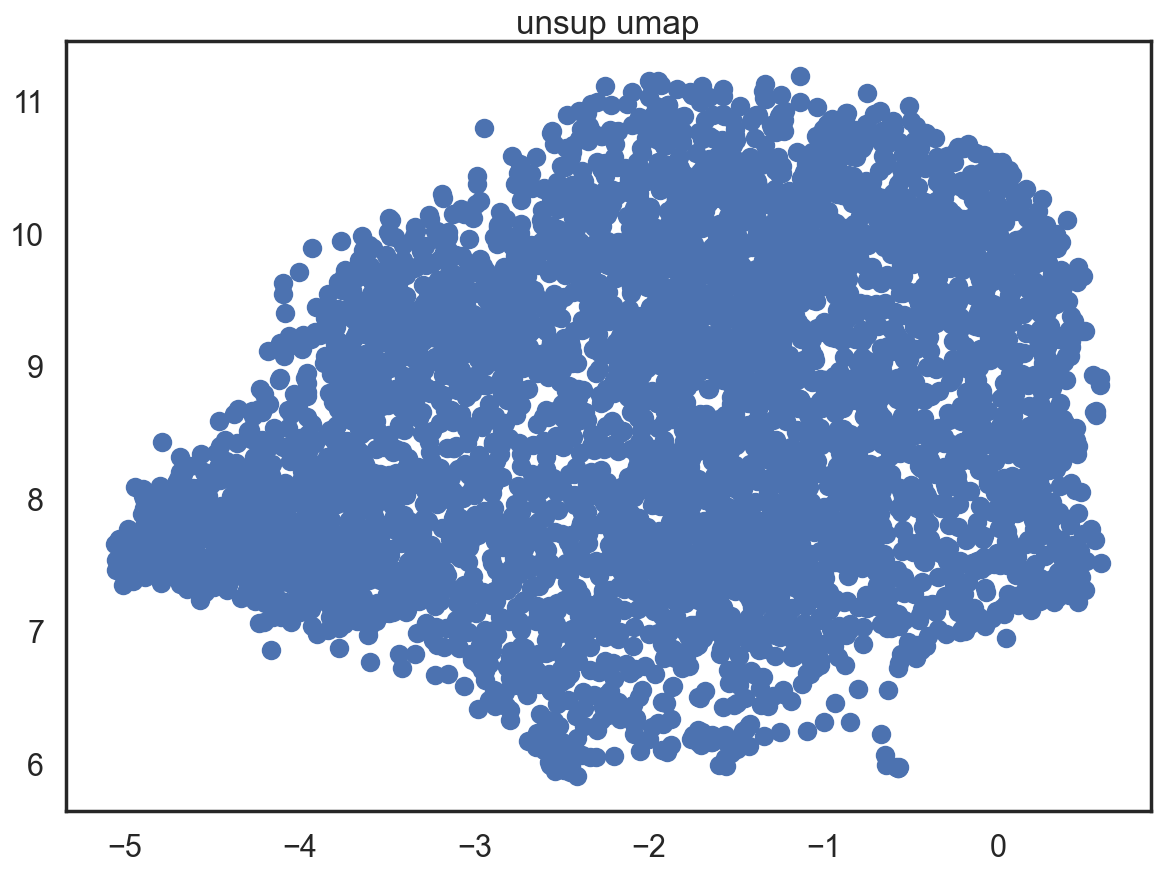

In [14]:
plt.figure(figsize=(14, 10))
plt.scatter(unsup_embedding[:, 0], unsup_embedding[:, 1])
plt.title('unsup umap')
plt.show()

okay so integer linear programming is totally unfeasible since solvers still explore something on the scale of literally every path. thus i shall use heuristic stuff. wait though. if i have a metric i believe in this is this basically slightly obfuscated direct programming? no. because umap guarantees distances satisfy triangle inequality. not sure if my metirc was originally triangleproof tho

okay so basically i'm going to implement christofides

In [23]:
christdists=np.zeros((batch_size, batch_size))
dists=[]
dist_ids=[]
for i in range(batch_size):
    for j in range(i+1, batch_size):
        edist=np.linalg.norm(unsup_embedding[i] -unsup_embedding[j])
        dists.append(edist)
        dist_ids.append((i, j))
        christdists[i, j]=edist

In [22]:
class disjointdataset:
    #parent array of reps
    def __init__(self, size):
        self.parent=list(range(size))
    def find(self, i):
        if self.parent[i]==i:
            return i
        return self.find(self.parent[i])
    def union(self, i, j):
        self.parent[self.find(i)]=self.find(j)

In [56]:
#find mst. kruskal's
sorted_pairs=sorted(zip(dists, dist_ids), key=lambda x:x[0])
mst = []
dd = disjointdataset(batch_size)
i=0


while len(mst)<batch_size-1 and i < len(sorted_pairs):
    #would including the smallest so far create a cycle
    dist, edge = sorted_pairs[i]
    x, y = edge
    
    if dd.find(x) != dd.find(y):
        dd.union(x, y)
        #if it does not, append it, otherwise skip it
        mst.append((x, y, dist))
    
    i+=1

In [57]:
#find odd degree vertices; create perfect matching of 
degrees = np.zeros(batch_size)
for u, v, distance in mst:
    degrees[u]+=1
    degrees[v]+=1

odd_degree_vertices = [i for i in range(batch_size) if degrees[i]%2==1] #indices
    

so for this exact point i'm a little lazy and will just 

In [ ]:
import networkx as net

def minimum_perfect_matching(odd_vertices, distance_matrix):
    graph = net.Graph()
    for vertex in odd_vertices:
        graph.add_node(vertex)
    for i in range(len(odd_vertices)):
        for j in range(i+1, len(odd_vertices)):
            graph.add_edge(odd_vertices[i], odd_vertices[j], weight = christdists[i, j])
            
    matching = net.algorithms.matching.min_weight_matching(graph, weight = 'weight')
    return matching
matching_edges = minimum_perfect_matching(odd_degree_vertices, dist)

TypeError: 'set' object is not subscriptable

In [86]:
mpm = [(u, v, christdists[u][v]) for u, v in matching_edges]
print(mpm)

[(2420, 1035, np.float64(0.0)), (3222, 4185, np.float64(3.6253762245178223)), (3408, 3647, np.float64(4.028554916381836)), (1373, 1757, np.float64(3.0029702186584473)), (2403, 4109, np.float64(2.7739529609680176)), (1014, 3563, np.float64(0.43995481729507446)), (3993, 126, np.float64(0.0)), (2772, 705, np.float64(0.0)), (2332, 4741, np.float64(2.6770288944244385)), (1194, 1553, np.float64(2.5445964336395264)), (719, 1659, np.float64(2.8897552490234375)), (19, 3392, np.float64(3.1520726680755615)), (3672, 4506, np.float64(1.9717336893081665)), (1461, 3959, np.float64(2.0202317237854004)), (481, 4478, np.float64(3.081214666366577)), (560, 2166, np.float64(1.0016368627548218)), (4676, 152, np.float64(0.0)), (1704, 3219, np.float64(2.1664083003997803)), (1255, 1239, np.float64(0.0)), (2528, 1939, np.float64(0.0)), (3924, 4605, np.float64(1.9921296834945679)), (1842, 169, np.float64(0.0)), (74, 740, np.float64(1.0695935487747192)), (1493, 4832, np.float64(3.711272954940796)), (1531, 4706, n

heirholzer's alg for eularian path finding

In [129]:
from multiset import *

together = mst + mpm #every edge now has even degree
adjacency_dictionary={}
for u, v, weight in together:
    if u not in adjacency_dictionary:
        adjacency_dictionary[u]=[]
    adjacency_dictionary[u].append((v,weight))
    if v not in adjacency_dictionary:
        adjacency_dictionary[v]=[]
    adjacency_dictionary[v].append((u, weight))

checkpoint: recreate extra_walk


In [132]:
def heirholzers(graph):
    if len(graph)==0:
        return []
    temp_path=[0]
    total_path=[]
    while len(temp_path)>0:
        current_node=temp_path[len(temp_path)-1]
        if len(graph[current_node])>0:
            next_node, _ = graph[current_node].pop()
            temp_path.append(next_node)
            
            for i, (neighbor, weight) in enumerate(graph[next_node]):
                if neighbor == current_node:
                    del graph[next_node][i]
                    break
        else:
            total_path.append(temp_path.pop())
    total_path.reverse()
    return total_path
graph = {node: neighbors.copy() for node, neighbors in adjacency_dictionary.items()}
extra_walk=heirholzers(graph)



[0, 3553, 68, 2670, 3657, 3185, 485, 4269, 3644, 3755, 4055, 3633, 3367, 2767, 1813, 2522, 3062, 1970, 1127, 3971, 4118, 1814, 1581, 3864, 2234, 856, 857, 1436, 2302, 3763, 3929, 2050, 469, 871, 1666, 1098, 1769, 864, 2852, 2853, 24, 1363, 463, 175, 1185, 870, 3022, 4804, 4651, 4698, 4617, 3065, 2472, 3449, 706, 668, 3333, 645, 792, 88, 2239, 1794, 1585, 1303, 1925, 3008, 1339, 3388, 1498, 4068, 4328, 927, 3556, 3803, 3410, 4558, 2569, 2025, 2566, 1959, 997, 1927, 522, 3826, 4286, 4334, 3004, 1609, 4439, 4904, 2089, 1649, 1519, 2656, 2654, 527, 4486, 802, 1806, 2091, 2339, 533, 986, 987, 1205, 260, 3341, 332, 4184, 1805, 2644, 3296, 2705, 2159, 445, 53, 2100, 4524, 242, 92, 547, 3939, 205, 4042, 3194, 3749, 4224, 2349, 4050, 2270, 3613, 4730, 424, 3835, 1515, 64, 400, 2916, 2376, 2652, 2235, 3394, 2972, 3585, 2725, 1848, 1076, 436, 4919, 4734, 4476, 3908, 4771, 4580, 4867, 2919, 239, 3964, 4896, 4569, 4426, 4771, 4857, 4262, 4858, 4600, 4663, 2837, 4922, 1454, 150, 579, 203, 200, 4750,

In [ ]:

seen= [None] * batch_size
for i, node in enumerate(extra_walk):
    if seen[node] is None:
        seen[node]=[i]
    else: 
        seen[node].append(i)
print(adjacency_dictionary)
remove = []
for node, sightings in enumerate(seen): #"node" seen at "sightings", index is of walk
    if len(sightings)>1:
        minimum = 0
        at = 0
        for sighting in sightings:
            left=0
            right=0
            over=0
            if sighting==0 or sighting==len(extra_walk)-1:
                continue
            for neighbor, distance in adjacency_dictionary[extra_walk[sighting]]:
                if neighbor==extra_walk[sighting-1]: 
                    left=distance
                if neighbor==extra_walk[sighting+1]: 
                    right=distance
            for neighbor, distance in adjacency_dictionary[extra_walk[sighting-1]]:
                if neighbor==extra_walk[sighting+1]:
                    over=distance
            if over-left-right<minimum:
                minimum=over-left-right
                at = sighting
        for sighting in sightings:
            if sighting != at:
                remove.append(sighting)

[0, 3553, 68, 2670, 3657, 3185, 485, 4269, 3644, 3755, 4055, 3633, 3367, 2767, 1813, 2522, 3062, 1970, 1127, 3971, 4118, 1814, 1581, 3864, 2234, 856, 857, 1436, 2302, 3763, 3929, 2050, 469, 871, 1666, 1098, 1769, 864, 2852, 2853, 24, 1363, 463, 175, 1185, 870, 3022, 4804, 4651, 4698, 4617, 3065, 2472, 3449, 706, 668, 3333, 645, 792, 88, 2239, 1794, 1585, 1303, 1925, 3008, 1339, 3388, 1498, 4068, 4328, 927, 3556, 3803, 3410, 4558, 2569, 2025, 2566, 1959, 997, 1927, 522, 3826, 4286, 4334, 3004, 1609, 4439, 4904, 2089, 1649, 1519, 2656, 2654, 527, 4486, 802, 1806, 2091, 2339, 533, 986, 987, 1205, 260, 3341, 332, 4184, 1805, 2644, 3296, 2705, 2159, 445, 53, 2100, 4524, 242, 92, 547, 3939, 205, 4042, 3194, 3749, 4224, 2349, 4050, 2270, 3613, 4730, 424, 3835, 1515, 64, 400, 2916, 2376, 2652, 2235, 3394, 2972, 3585, 2725, 1848, 1076, 436, 4919, 4734, 4476, 3908, 4771, 4580, 4867, 2919, 239, 3964, 4896, 4569, 4426, 4771, 4857, 4262, 4858, 4600, 4663, 2837, 4922, 1454, 150, 579, 203, 200, 4750,

In [145]:
remove.sort(reverse=True)
for i, node in enumerate(remove):
    del(extra_walk[node])
print(extra_walk)
#don't run this multiple times

[0, 3553, 68, 2670, 3657, 3185, 3644, 3755, 4055, 3633, 3367, 2767, 1813, 2522, 3062, 1970, 1127, 3971, 1814, 1581, 3864, 2234, 856, 857, 1436, 2302, 3763, 3929, 2050, 469, 871, 1098, 1769, 864, 2852, 2853, 24, 1363, 463, 175, 1185, 870, 3022, 4804, 4651, 4698, 4617, 3065, 2472, 3449, 706, 668, 3333, 645, 792, 88, 2239, 1794, 1585, 1303, 1925, 3008, 1339, 3388, 1498, 4068, 4328, 927, 3556, 3803, 3410, 4558, 2569, 2025, 2566, 1959, 997, 3826, 4286, 4334, 3004, 1609, 4439, 4904, 2089, 1519, 2656, 2654, 527, 4486, 802, 1806, 2091, 2339, 533, 986, 987, 1205, 260, 3341, 332, 4184, 1805, 2644, 3296, 2705, 2159, 445, 53, 2100, 4524, 242, 92, 547, 3939, 205, 4042, 3194, 3749, 4224, 2349, 4050, 2270, 4730, 424, 3835, 1515, 64, 400, 2916, 2376, 2652, 2235, 3394, 2972, 2725, 1848, 1076, 436, 4919, 4734, 4476, 3908, 4771, 4580, 4867, 2919, 239, 3964, 4896, 4569, 4426, 4857, 4262, 4858, 4600, 4663, 2837, 4922, 1454, 150, 579, 203, 200, 4750, 4482, 2231, 2346, 4777, 4743, 3730, 2765, 1213, 1840, 408